# Functionality analysis

In [1]:
from sklearn.externals import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import importlib
importlib.reload(plt)

<module 'matplotlib.pyplot' from 'C:\\Program Files (x86)\\Microsoft Visual Studio\\Shared\\Anaconda3_86\\lib\\site-packages\\matplotlib\\pyplot.py'>

# Build the data

In [2]:
accepted_solutions = joblib.load("C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\vrpldtt_freytag\\Fu1_1_accepted.pkl")

In [3]:
visited_solutions = joblib.load("C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\vrpldtt_freytag\\Fu1_1_visited.pkl")

In [4]:
def parse_data(raw_dat):
    dat = {}

    for solution in raw_dat: 
        row = {"running value": solution.value,
              "running qual": solution.quality,
              "running feas": int(solution.is_feasible),
              "sol rep": solution.solution}

        dat[raw_dat[solution]] = row

    df = pd.DataFrame.from_dict(dat, orient="index")
    df["time in s"] = (df.index - min(df.index)) / 1000
    df.sort_index(inplace =True)
    return df

In [5]:
acc_df = parse_data(accepted_solutions) 
vis_df = parse_data(visited_solutions) 

# Do postprocessing

In [6]:
# 1) Add best value info
best_value = np.inf
best_rep = None

current_values = []
current_acc_rep = []

best_values = []
best_acc_rep = []

for row in vis_df.index:    
    # Add info about current accepted solution
    if best_value > vis_df.loc[row, "running value"]:
        best_value = vis_df.loc[row, "running value"]
        best_rep = vis_df.loc[row, "sol rep"]
        
    best_values.append(best_value)
    best_acc_rep.append(best_rep)
    
    try:
        current_values.append(acc_df.loc[row, "running value"])
        current_acc_rep.append(acc_df.loc[row, "sol rep"])
    except KeyError:
        current_values.append(current_values[-1])
        current_acc_rep.append(current_acc_rep[-1])

vis_df["acc sol rep"] = current_acc_rep
vis_df["best rep"] = best_acc_rep

vis_df["current value"] = current_values
vis_df["best value"] = best_values

In [7]:
def get_prec_post(sol):
    prec_post = {}
    
    for rid, route in enumerate(sol):
        prev = 0
        for nid, node in enumerate(route):
            try:
                prec_post[node] = [prev, route[nid+1]]
            except IndexError:
                prec_post[node] = [prev, 0]
            
    return prec_post

def hamming_distance(sol1, sol2):
    s1 = get_prec_post(sol1)
    s2 = get_prec_post(sol2)
    
    hamming_dist = 0
    for node in s2:
        hamming_dist += (s2[node][0] != s1[node][0])
        hamming_dist += (s2[node][1] != s1[node][1])

    return hamming_dist

#TVERSKY’S SIMILARITY MEASURE
def tversky_similarity(sol1, sol2):
    only_1 = 0
    only_2 = 0
    both = 0
    for rid in range(len(sol1)):
        for nid, node in enumerate(sol1[rid]):
            if node in sol2[rid]:
                both += 1
            else:
                only_1 += 1
                
        for nid, node in enumerate(sol2[rid]):
            if node in sol1[rid]:
                both += 1
            else:
                only_2 += 1
                
    return both / (both + only_1 + only_2)
    

In [8]:
curren_sol_dist = [0]
best_sol_dist = [0]
current_best_dist = [0]

for row in vis_df.index[1:]:
    curren_sol_dist.append(hamming_distance(vis_df.loc[row, "sol rep"], vis_df.loc[row, "acc sol rep"]))
    best_sol_dist.append(hamming_distance(vis_df.loc[row, "sol rep"], vis_df.loc[row, "best rep"]))
    current_best_dist.append(hamming_distance(vis_df.loc[row, "acc sol rep"], vis_df.loc[row, "best rep"]))
    
vis_df["hamming distance"] = curren_sol_dist
vis_df["hamming distance best"] = best_sol_dist
vis_df["hamming distance curr best"] = current_best_dist

Time in s is the only relevant visualization because in later stages there might be no new solution!

## Shake-up of solution (diversification in one iteration)

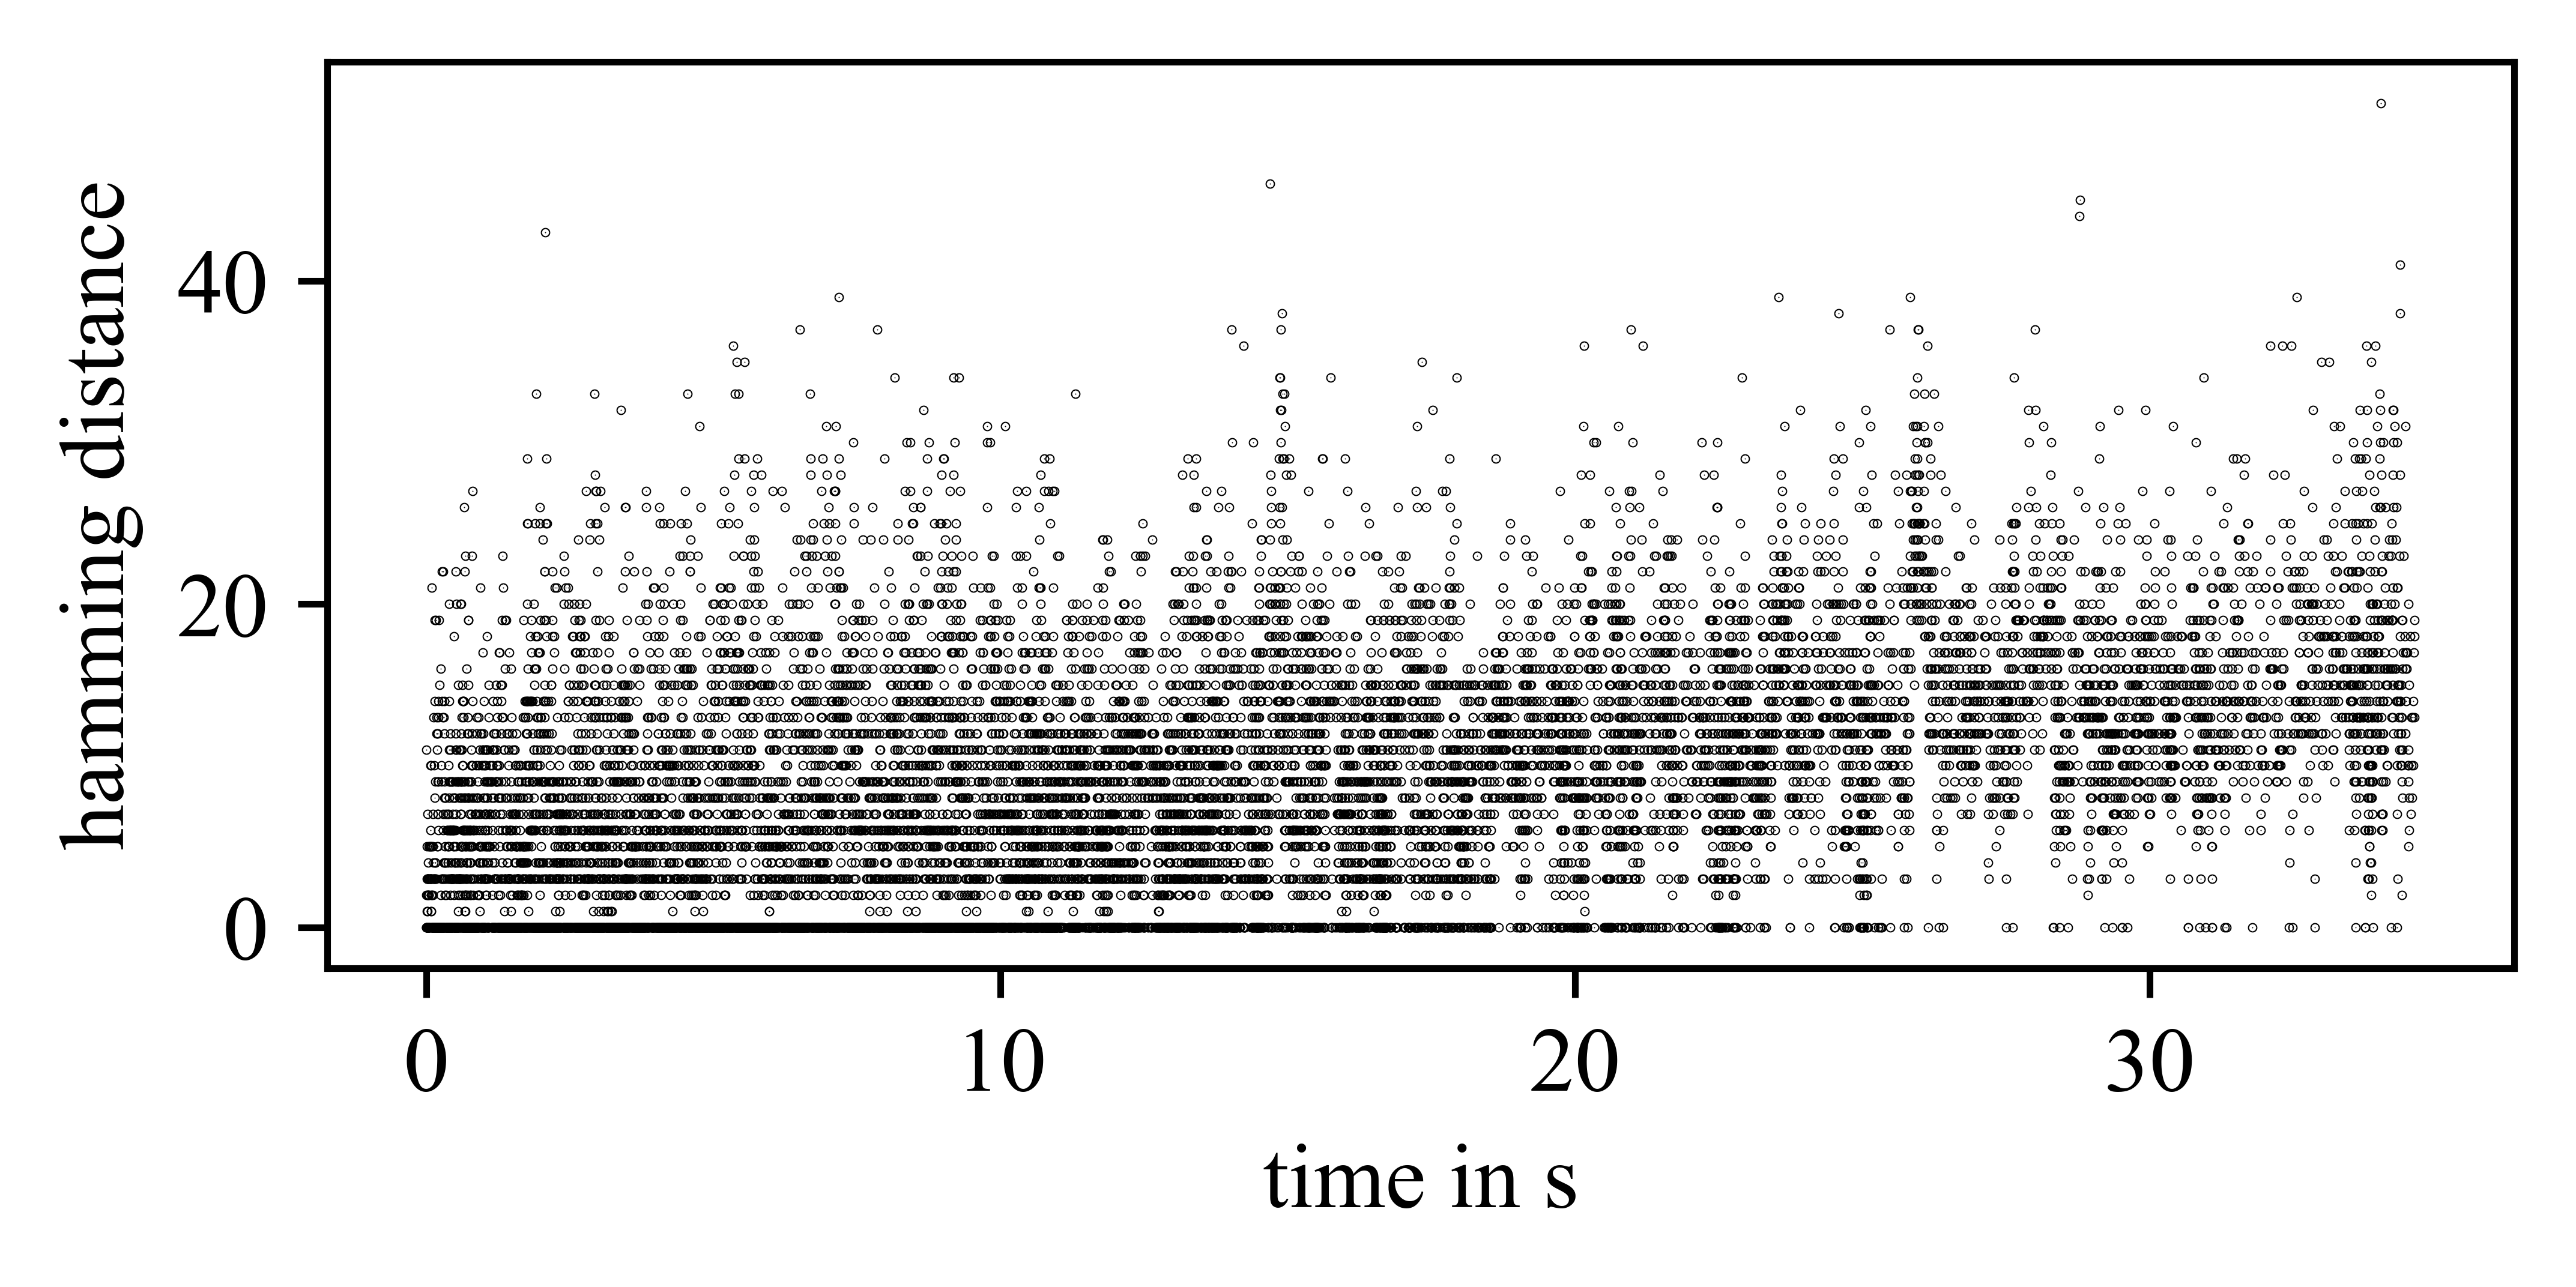

In [9]:
plt.style.use(("grayscale", "paper_hoch_flach"))
vis_df.iloc[5: ,].plot.scatter(x="time in s", y="hamming distance", s=0.02, color="black")

## Created solution quality and diversity

**Observations:**  
1) Quality difference increases in the intensification region (shake-up is increased an on full force)  
2) Distance never reaches the same heights as in the beginning (Natural limit to the search region)  


**Discussion:**  
-> INitial phase: Find best region  
-> Final phase: Intensification of search area  
-> Shake-up: Allow the intensification of an incrementally larger area around the bks  

Search region is extended by the shake-up but without the non-probabilistic tendencies of the acceptance criteria centers around the main BK

**Problem:**
Heuristics might perform poorly after for hugely destroyed solutions.  
-> Might introduce more intensive heuristics
Especially after the large weighting is based on execution time now?a larger 

Text(0,0.5,'hamming distance')

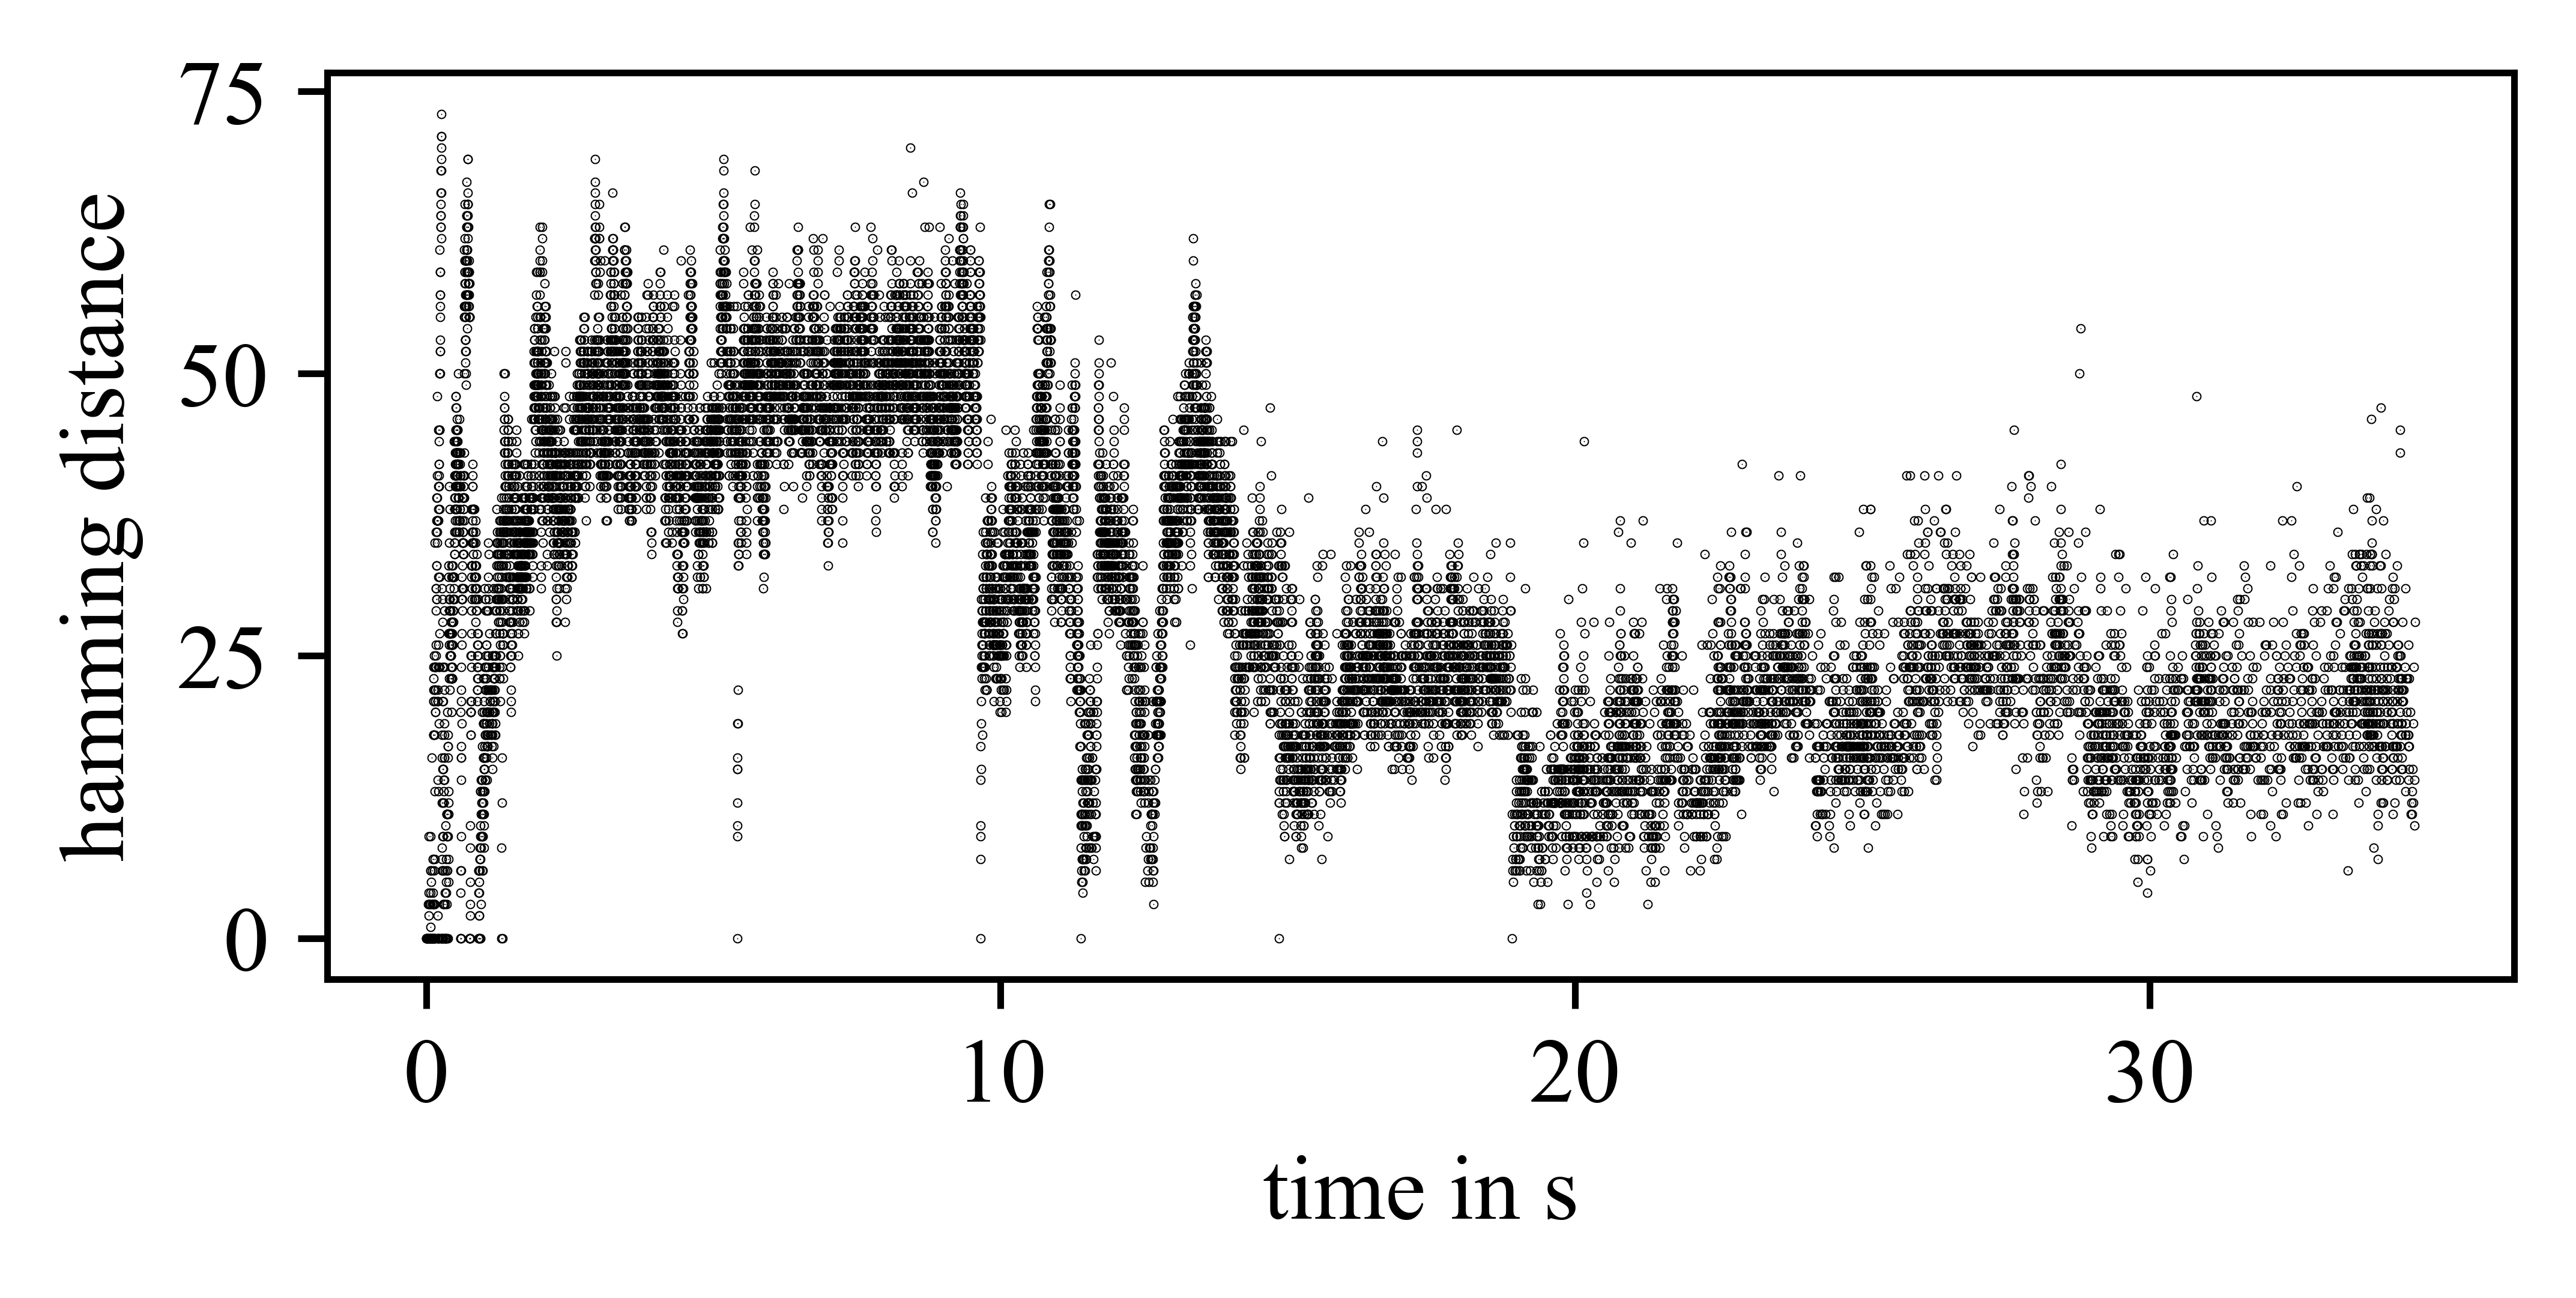

In [10]:
plt.style.use(("grayscale", "paper_hoch_flach"))
ax = vis_df.iloc[5: ,].plot.scatter(x="time in s", y="hamming distance best", s=0.02, color="black")
ax.set_ylabel("hamming distance")

Text(0,0.5,'travel time')

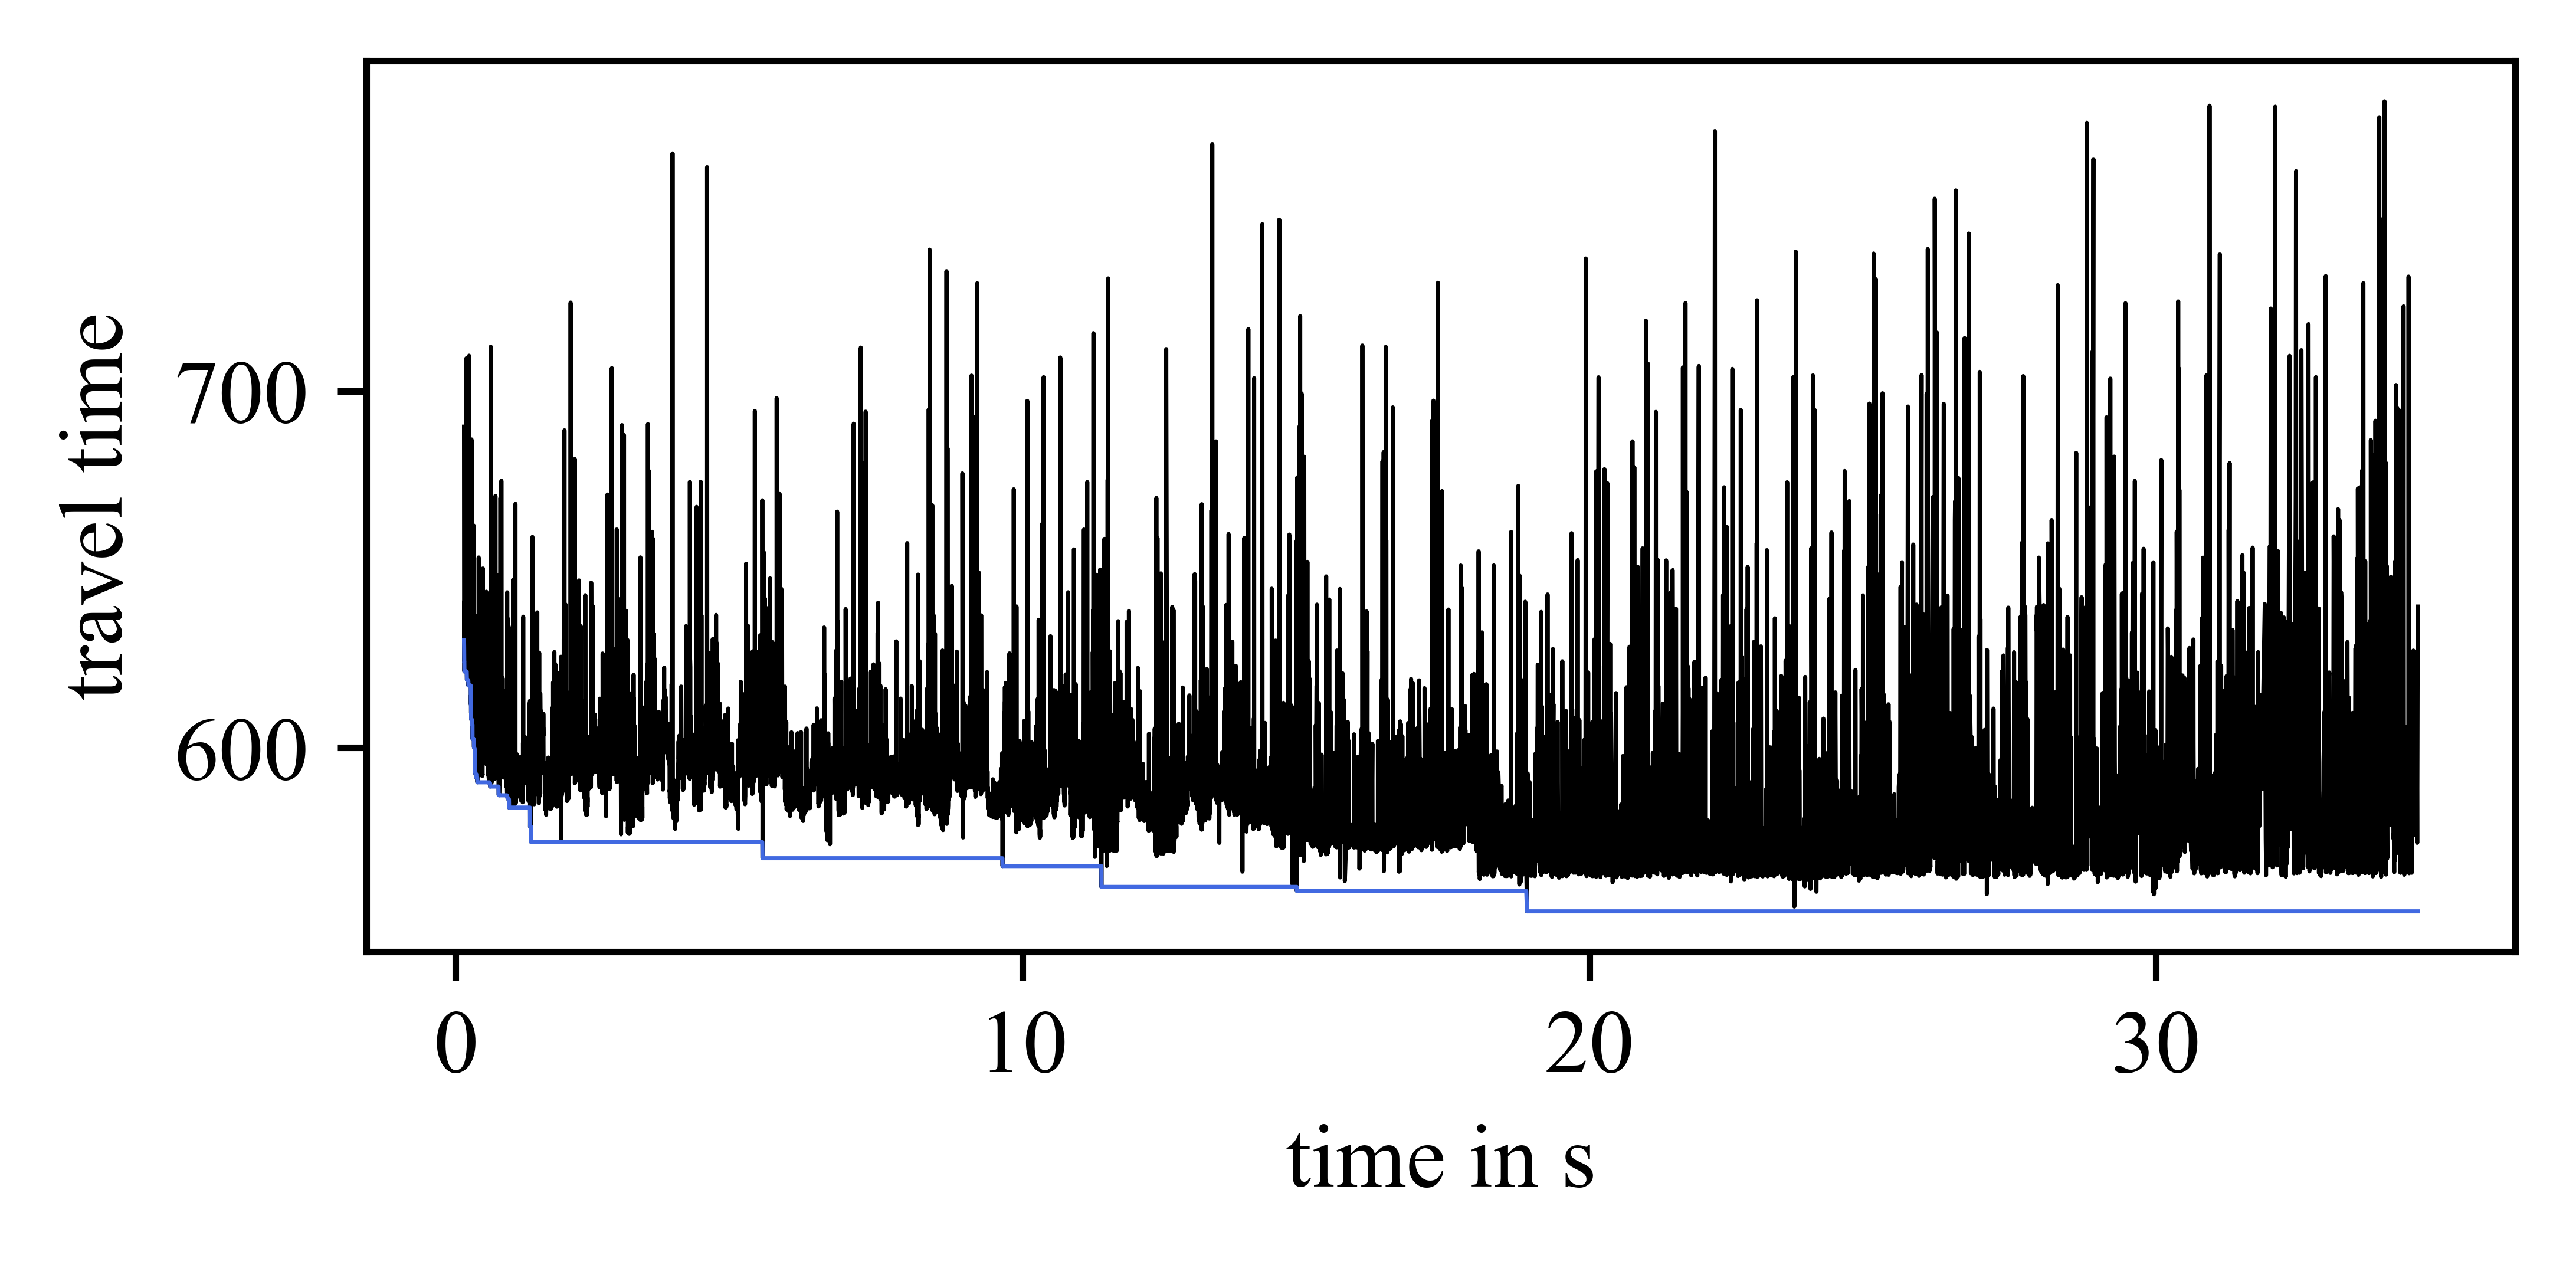

In [11]:
plt.style.use(("grayscale", "paper_hoch_flach"))
ax=vis_df.iloc[100: ,].plot(x="time in s", y=["running value", "best value"], linewidth=0.5, color=("black","royalblue"), legend=False)
ax.set_ylabel("travel time")

## Current solution quality and diversity

**Observations**  
1) The number of accepted solutions in the end is drastically reduced. This leads to a lower spread in hamming distances  
2) The max distance of the candidates is lower than the beginning. -> Can not make so huge leaps anymore because of less dynamics in the current solution  
3) Periodic return to the original search space in the convergence area (sec 20-35)  
4) High quality consistency for each accepted solution

**Discussion:**  
TODO

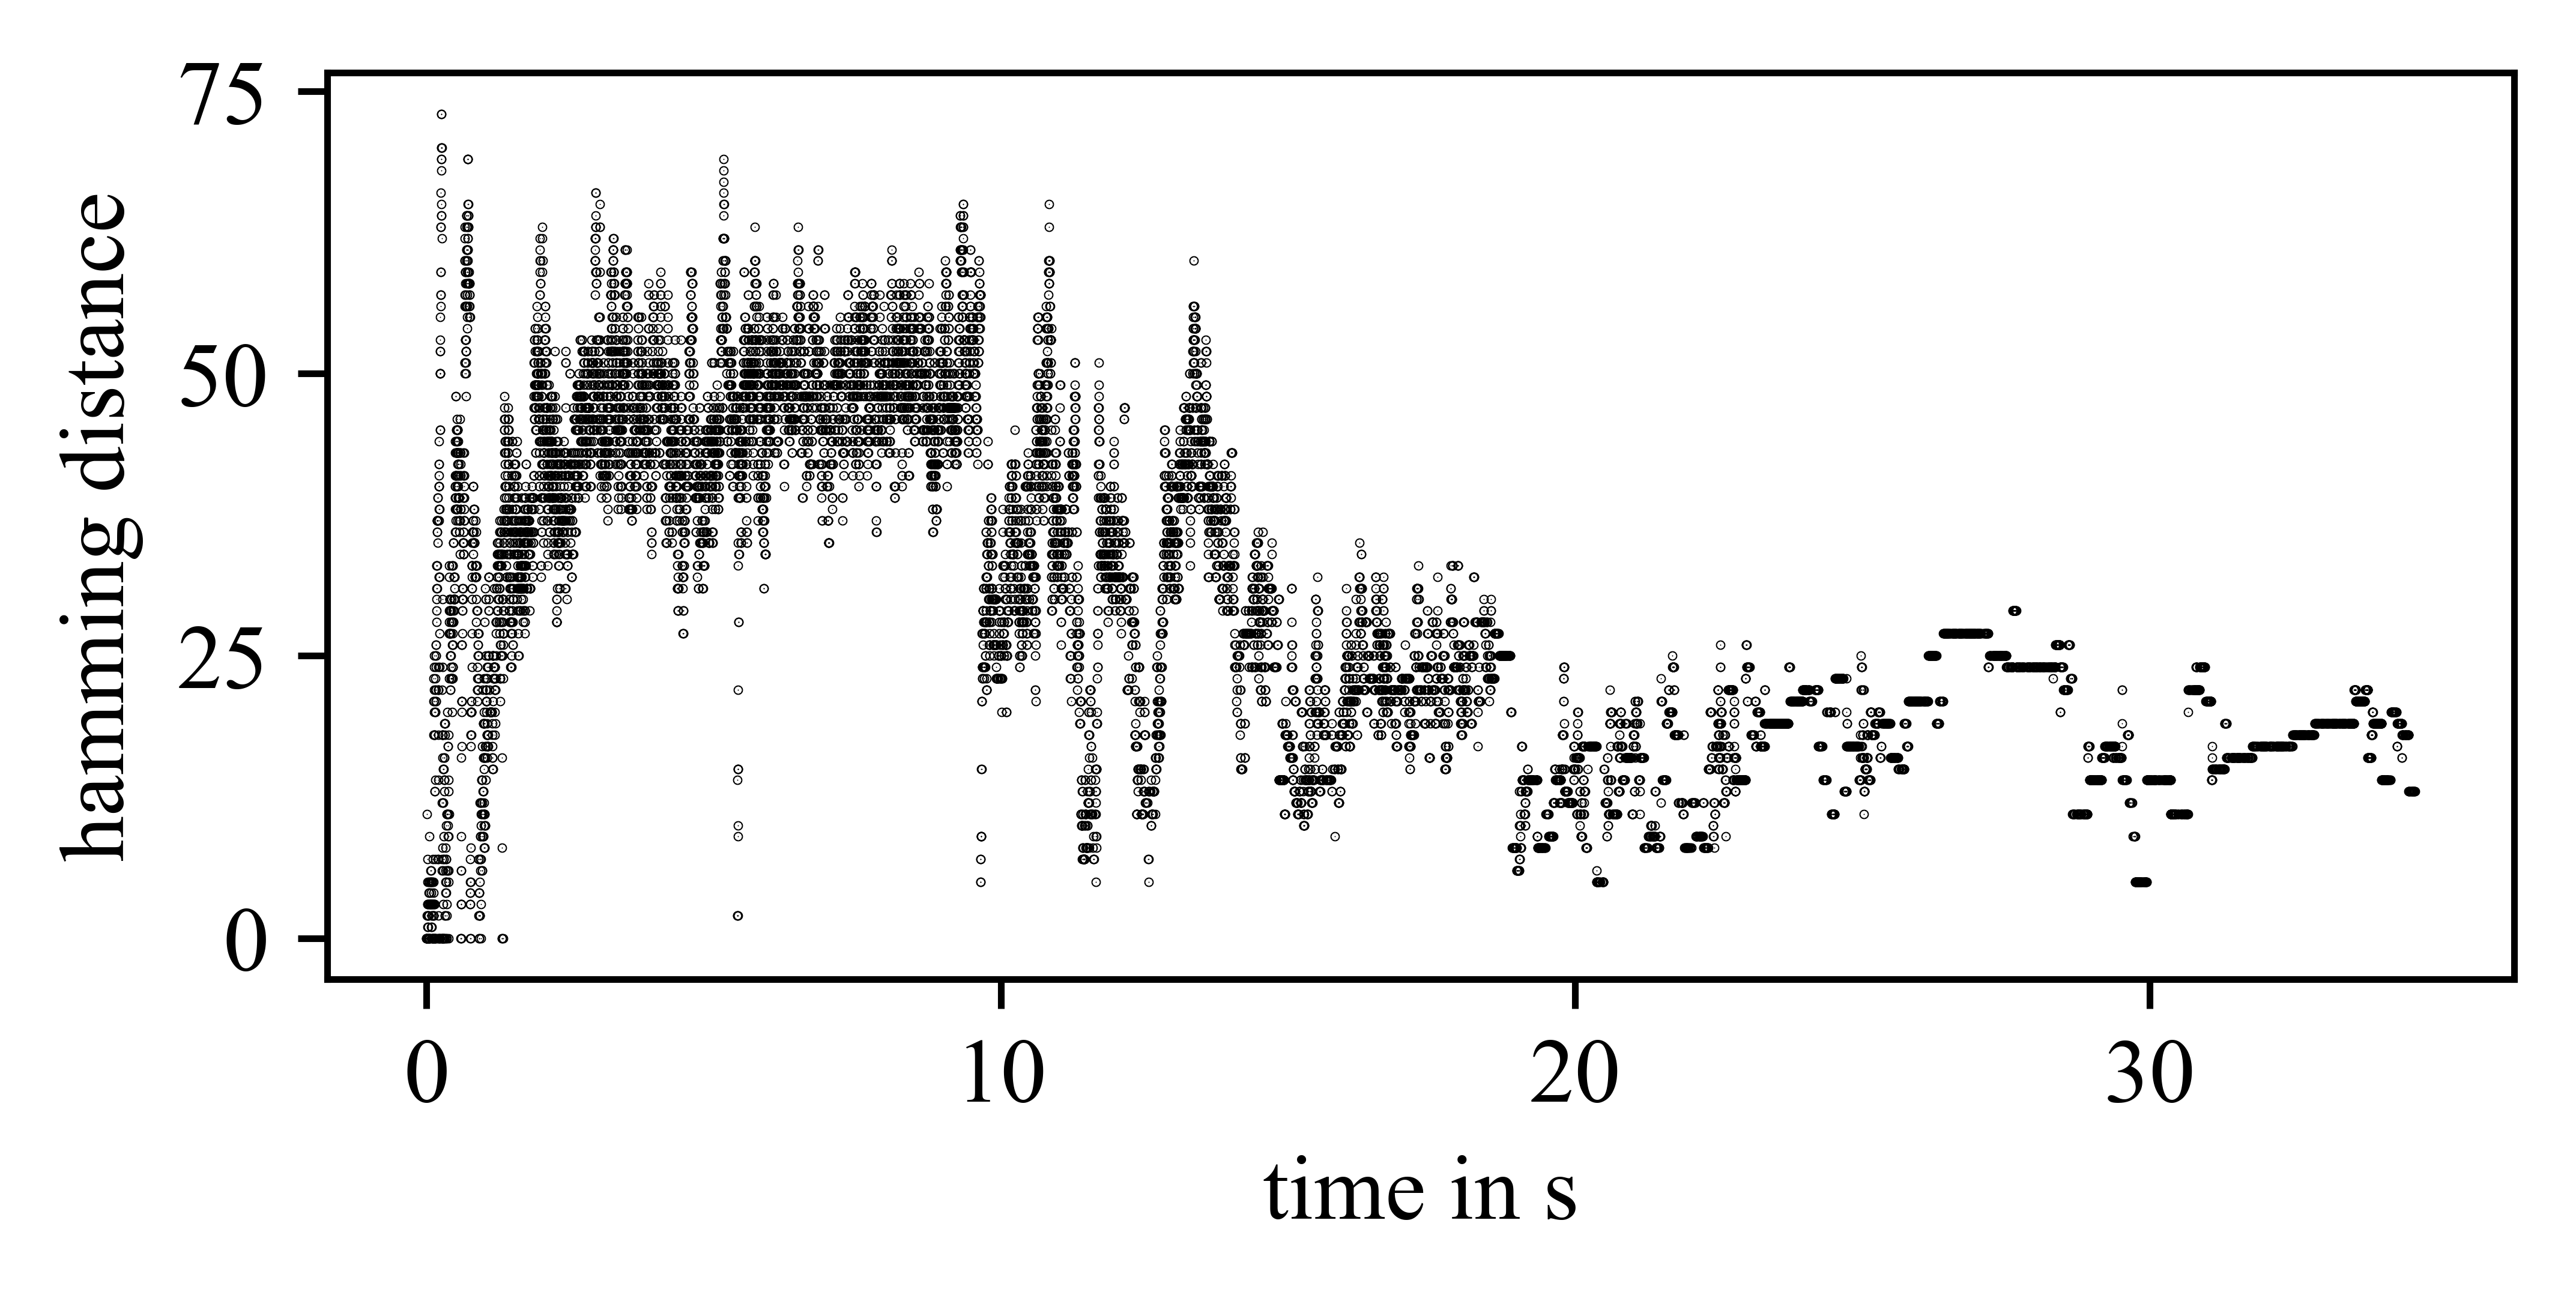

In [12]:
plt.style.use(("grayscale", "paper_hoch_flach"))
ax = vis_df.iloc[: ,].plot.scatter(x="time in s", y="hamming distance curr best", s=0.02, color="black")
ax.set_ylabel("hamming distance")
plt.show()

Text(0,0.5,'travel time')

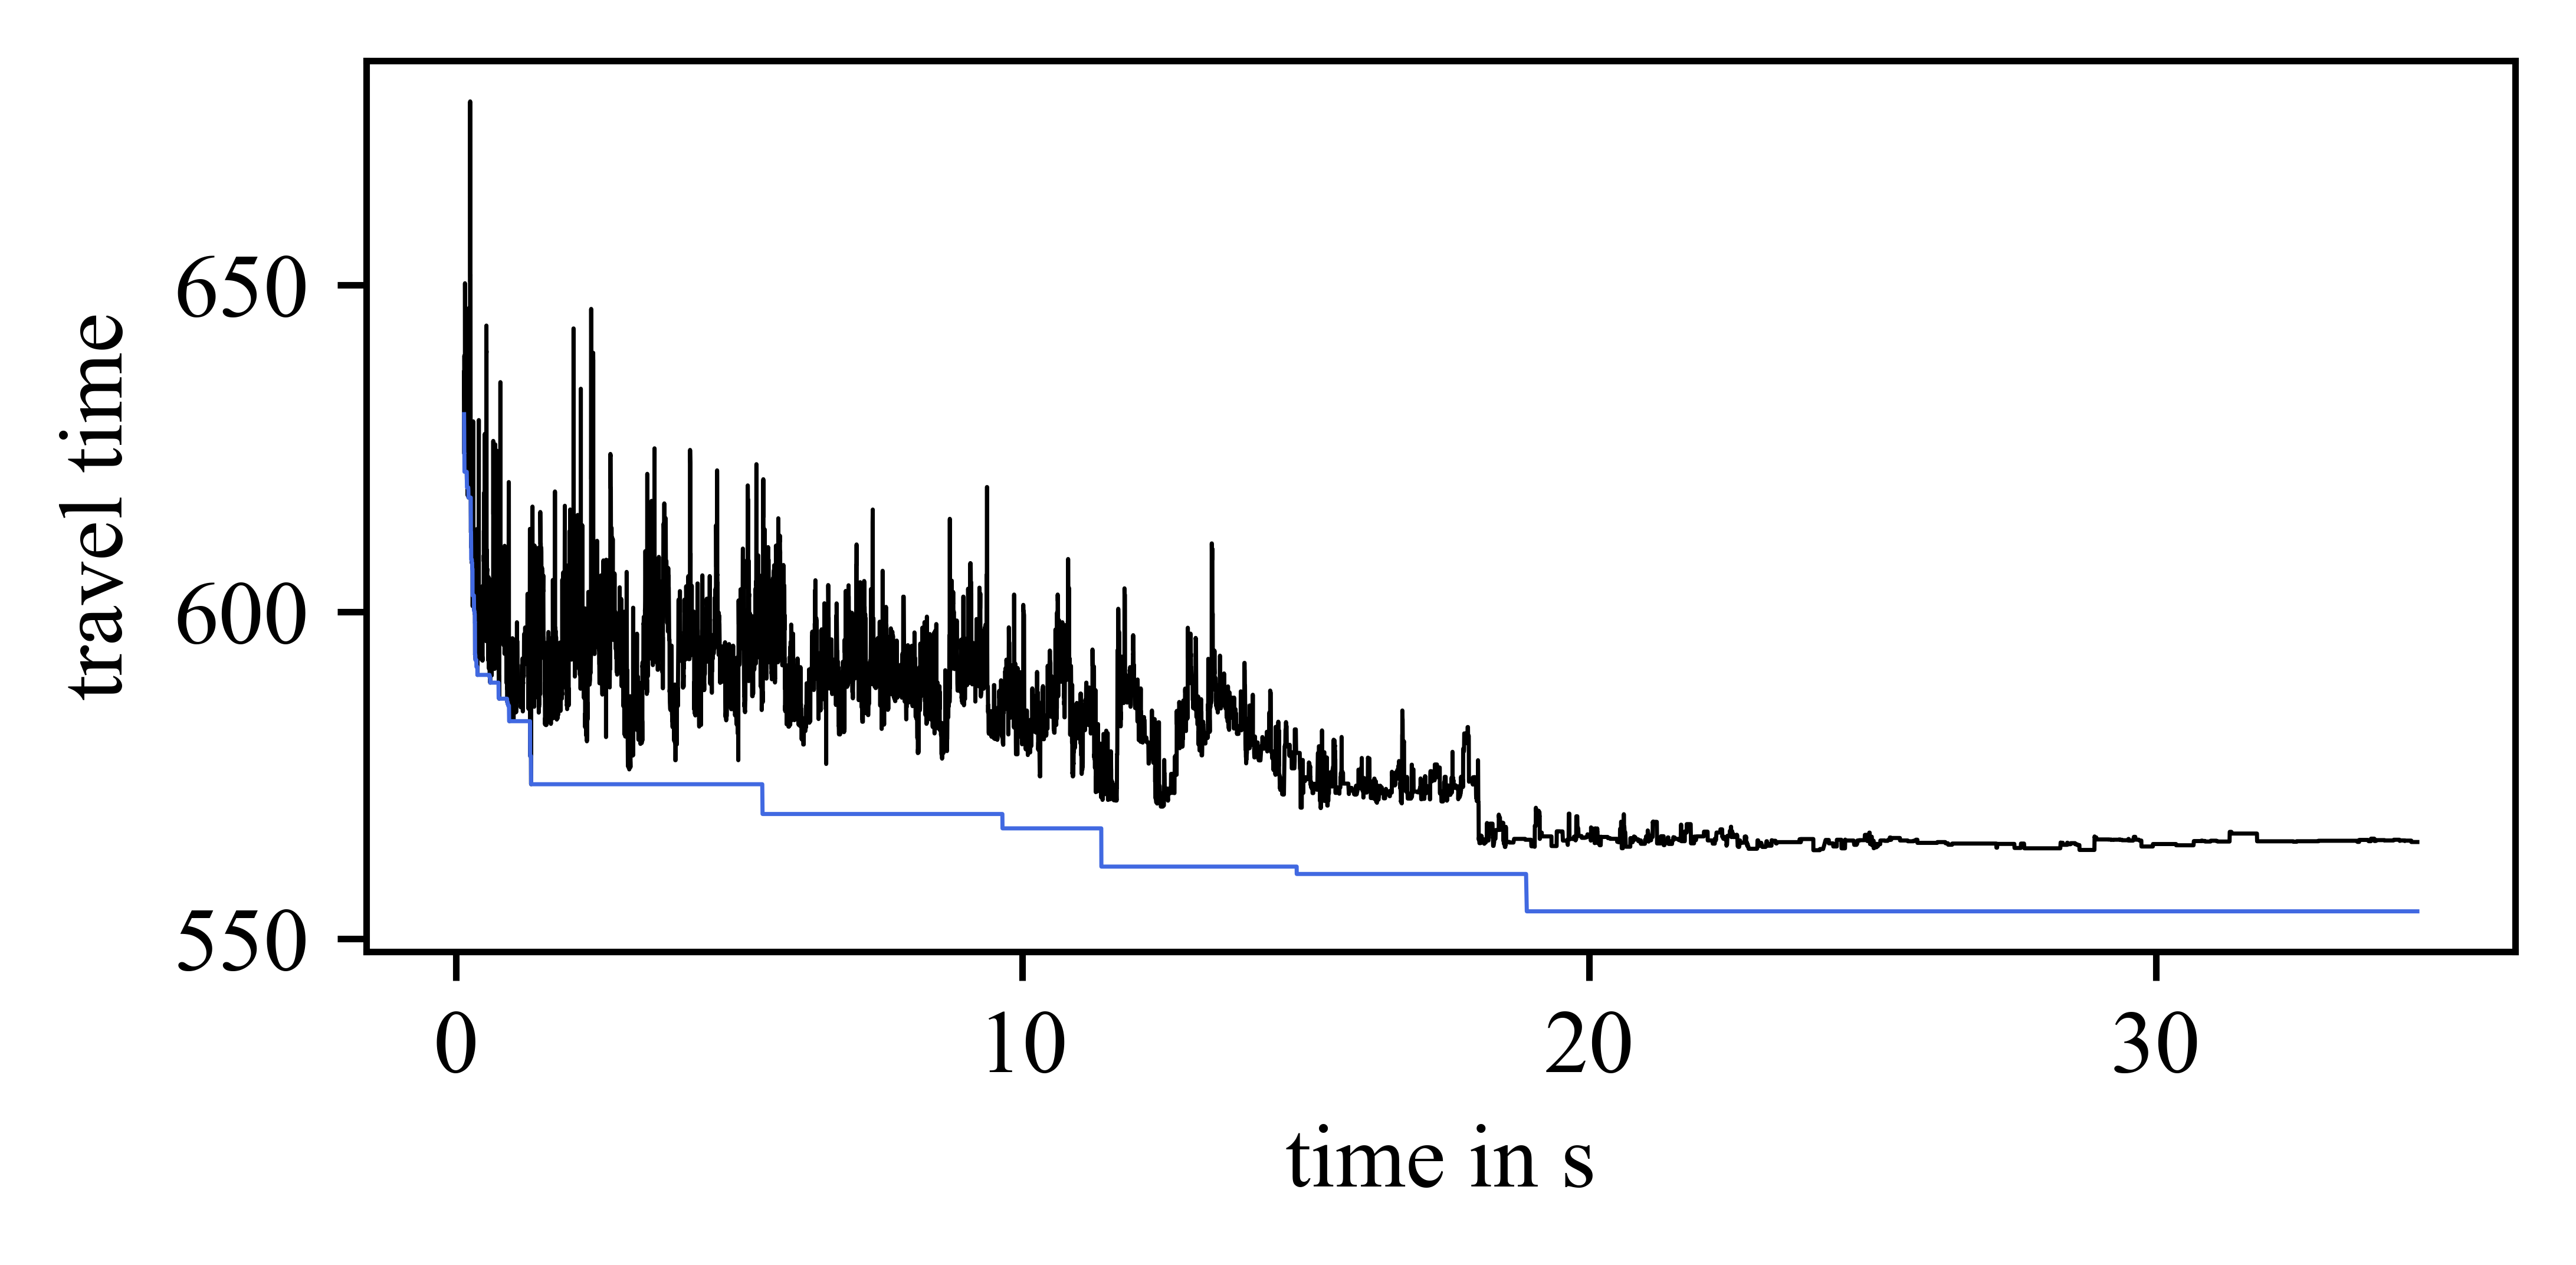

In [13]:
plt.style.use(("grayscale", "paper_hoch_flach"))
ax = vis_df.iloc[100: ,].plot(x="time in s", y=["current value", "best value"], linewidth=0.5, color=("black","royalblue"), legend=False)
ax.set_ylabel("travel time")

# 2) Average solution quality over time

In [11]:
rep_df = pd.read_excel("C:/Users/manuf/OneDrive/Dokumente/Universitaet/Masterthesis/data/1_tuning_results/runtime_weights_infeas_iter.xlsx", "destroy")

In [12]:
tmp_df = pd.DataFrame()
prev = None
for col in rep_df.columns[:-1]:
    if prev is None:
        tmp_df[col] = rep_df[col]
        prev = col
    else:
        tmp_df[col] = tmp_df[prev] + rep_df[col]
        prev = col
        
tmp_df["iter"] = rep_df["iter"]

(0, 410000)

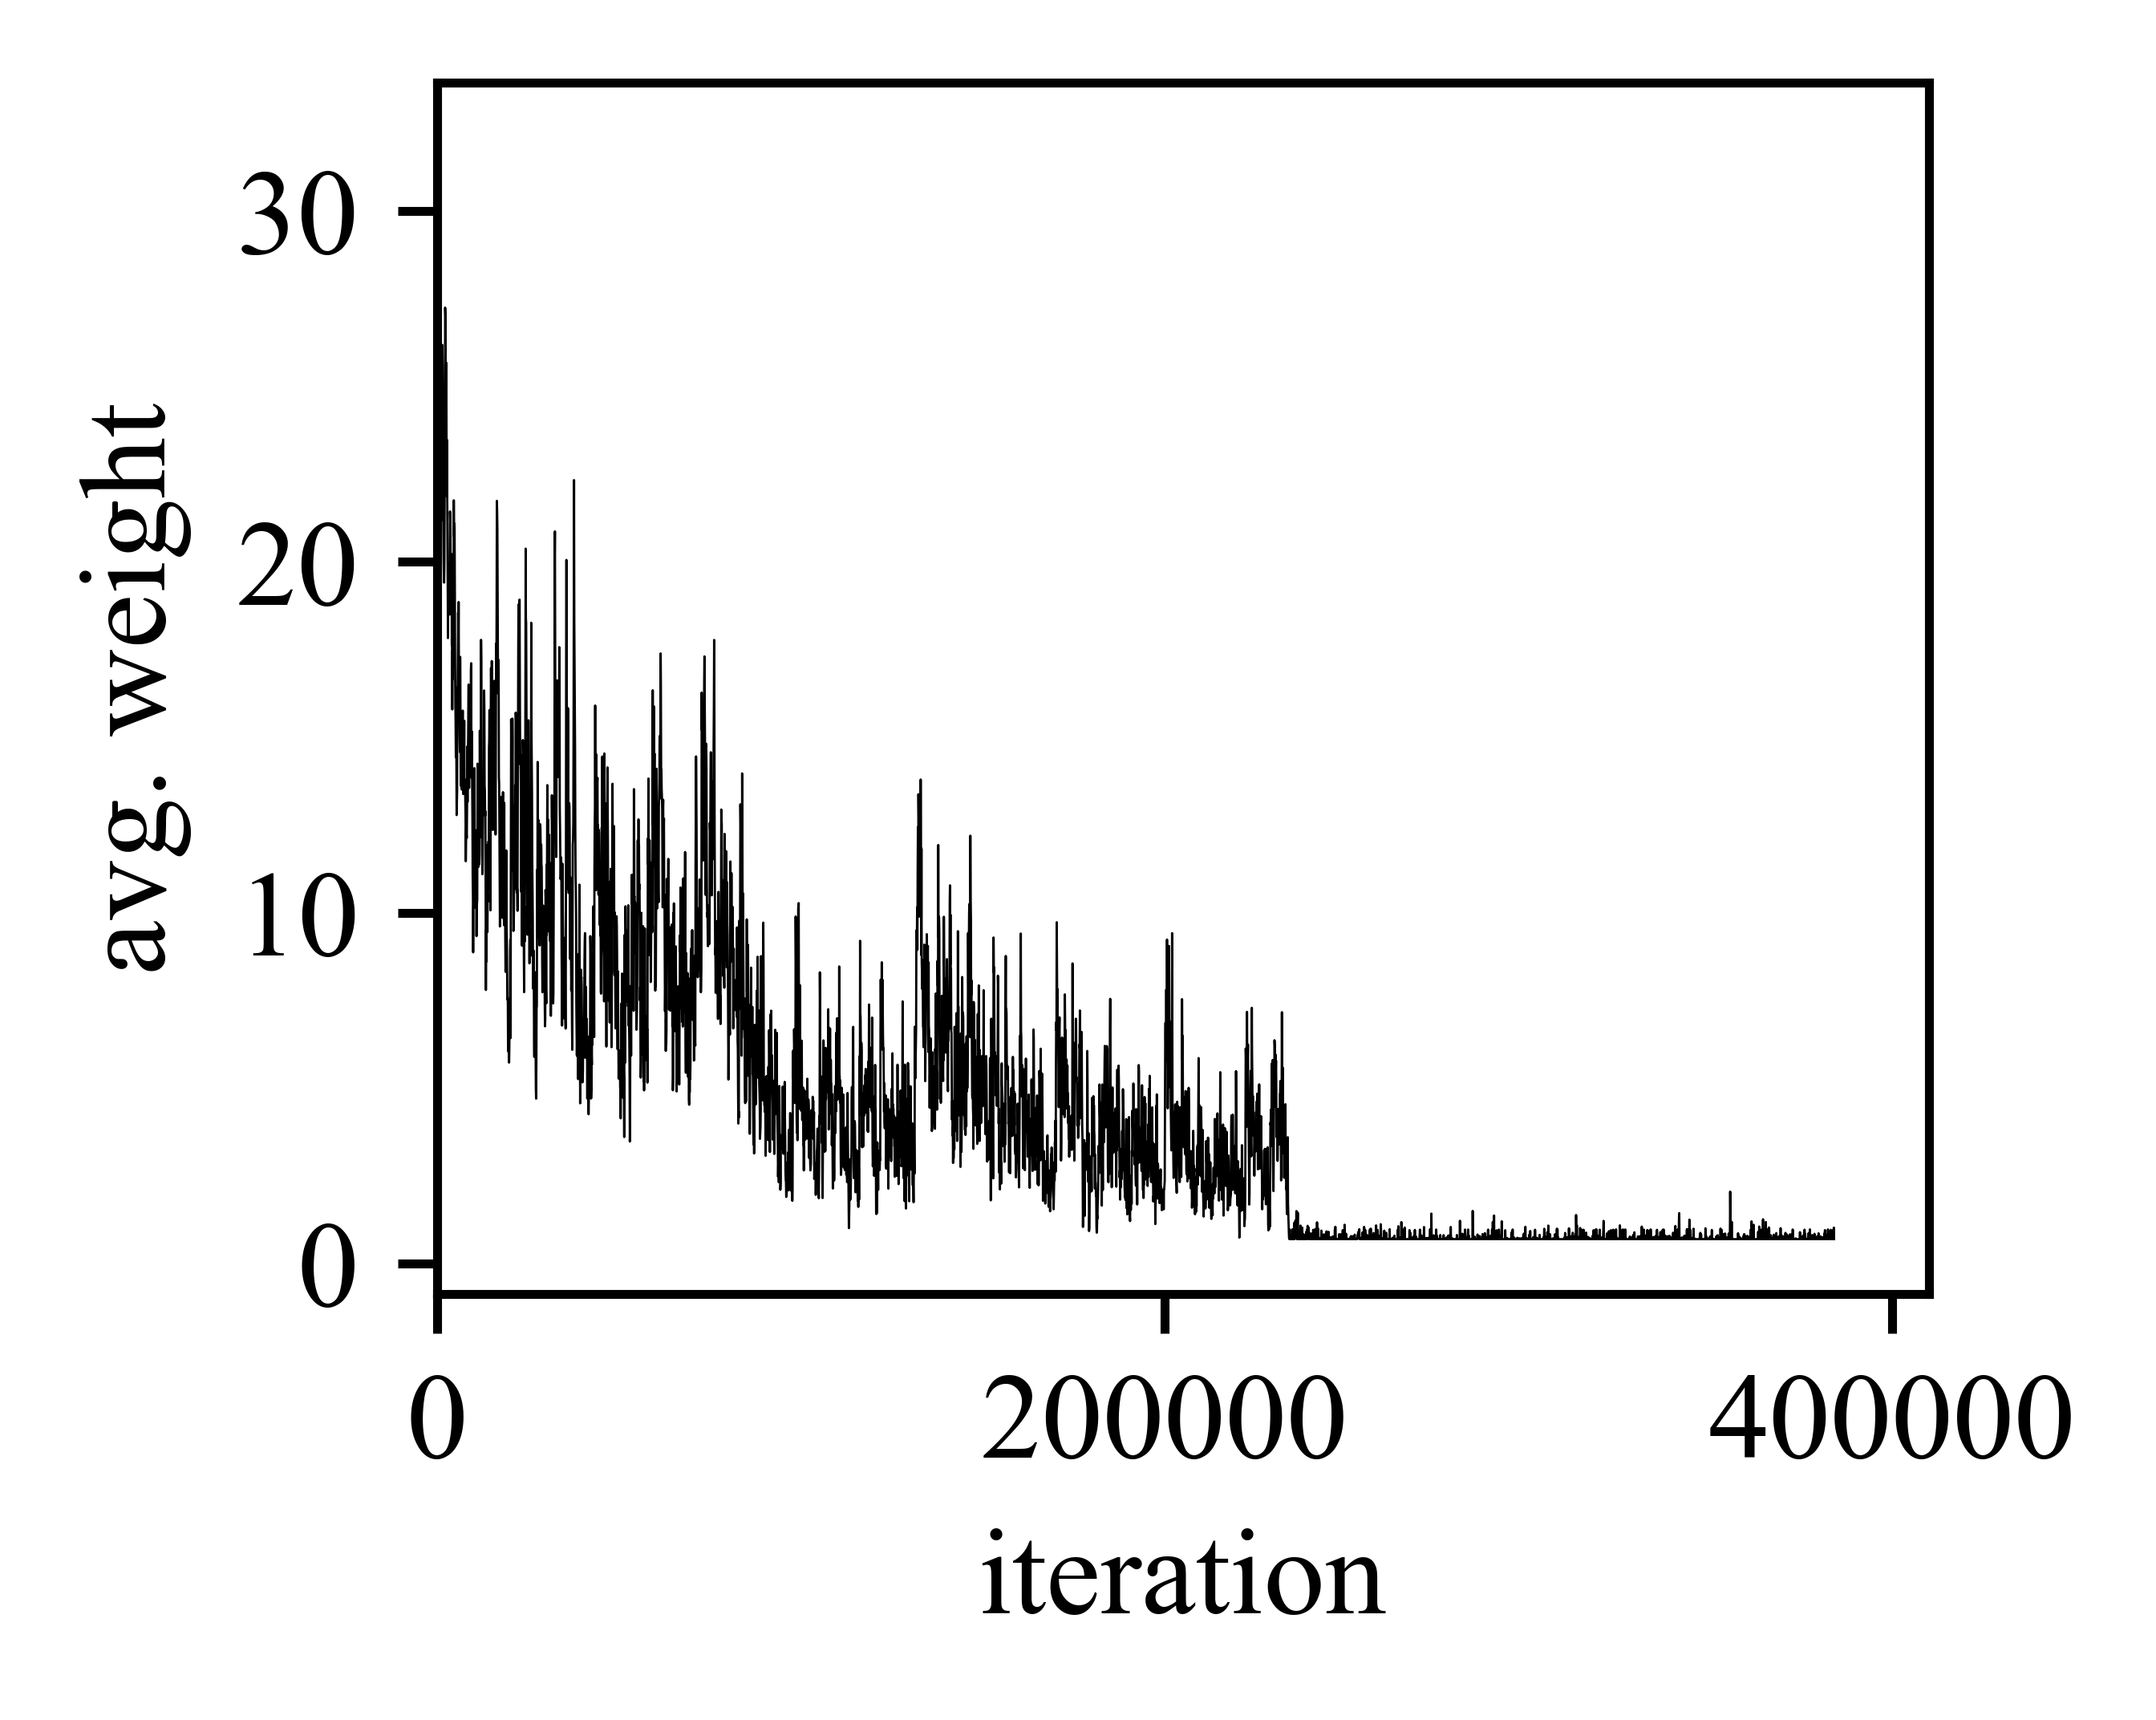

In [26]:
plt.style.use(("grayscale", "paper_hoch2"))
x = tmp_df["iter"]
y1 = tmp_df.iloc[:,-2]/10


plt.plot(x, y1, linewidth=0.2)
plt.ylabel("avg. weight")
plt.xlabel("iteration")
plt.xlim(0, 410000)

# 2.1) Selection probability

In [13]:
# Normalize value sum to 1
plt.style.use(("grayscale", "paper_quer"))
for col in tmp_df.columns[:-1]:
    tmp_df[col] = tmp_df[col]/tmp_df.iloc[:,-2]

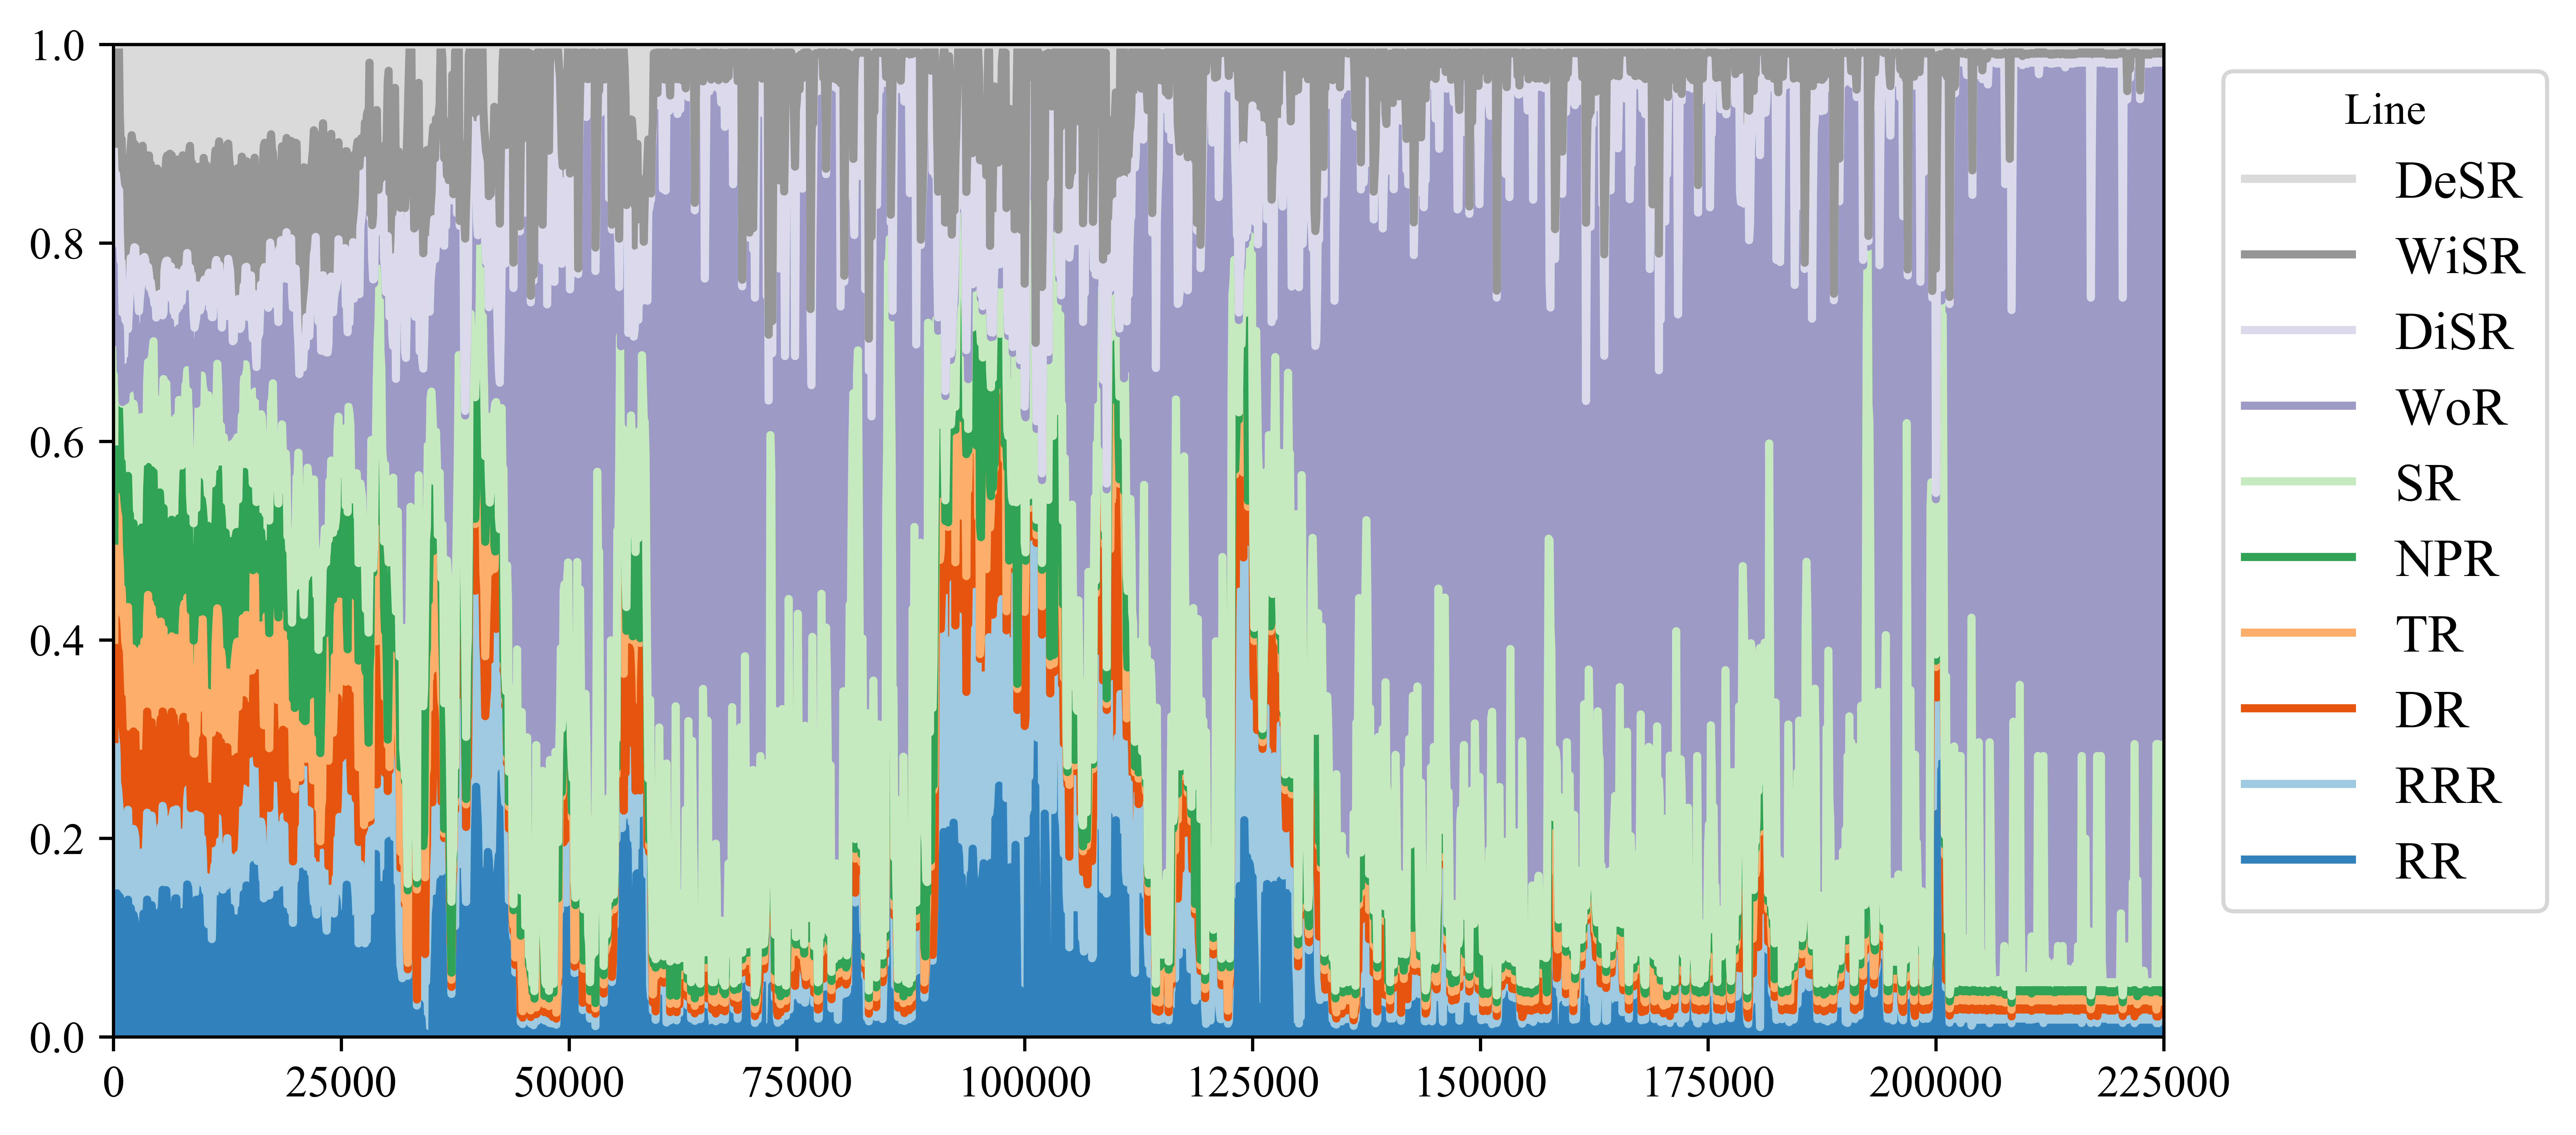

In [14]:
from cycler import cycler

nr_inst = 7000
p, ax = plt.subplots()

color=list(plt.cm.tab20c(np.linspace(0,1,10)))

prev_y = 0
for i, col in enumerate(tmp_df.columns[:-1]):
    x = tmp_df.iloc[:nr_inst, -1]
    y = tmp_df.loc[:nr_inst-1, col]
    
    c=color[i]
    ax.plot(x, y, linewidth=2, color=c)
    ax.fill_between(x, prev_y, y, color=c)
    prev_y = y

ax.legend(tmp_df.columns[:-1])
ax.set_xlim(0, 225000)
ax.set_ylim(0, 1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Line', loc='upper right', bbox_to_anchor=(1.2, 1))

# 3) Infeasibility behaviour

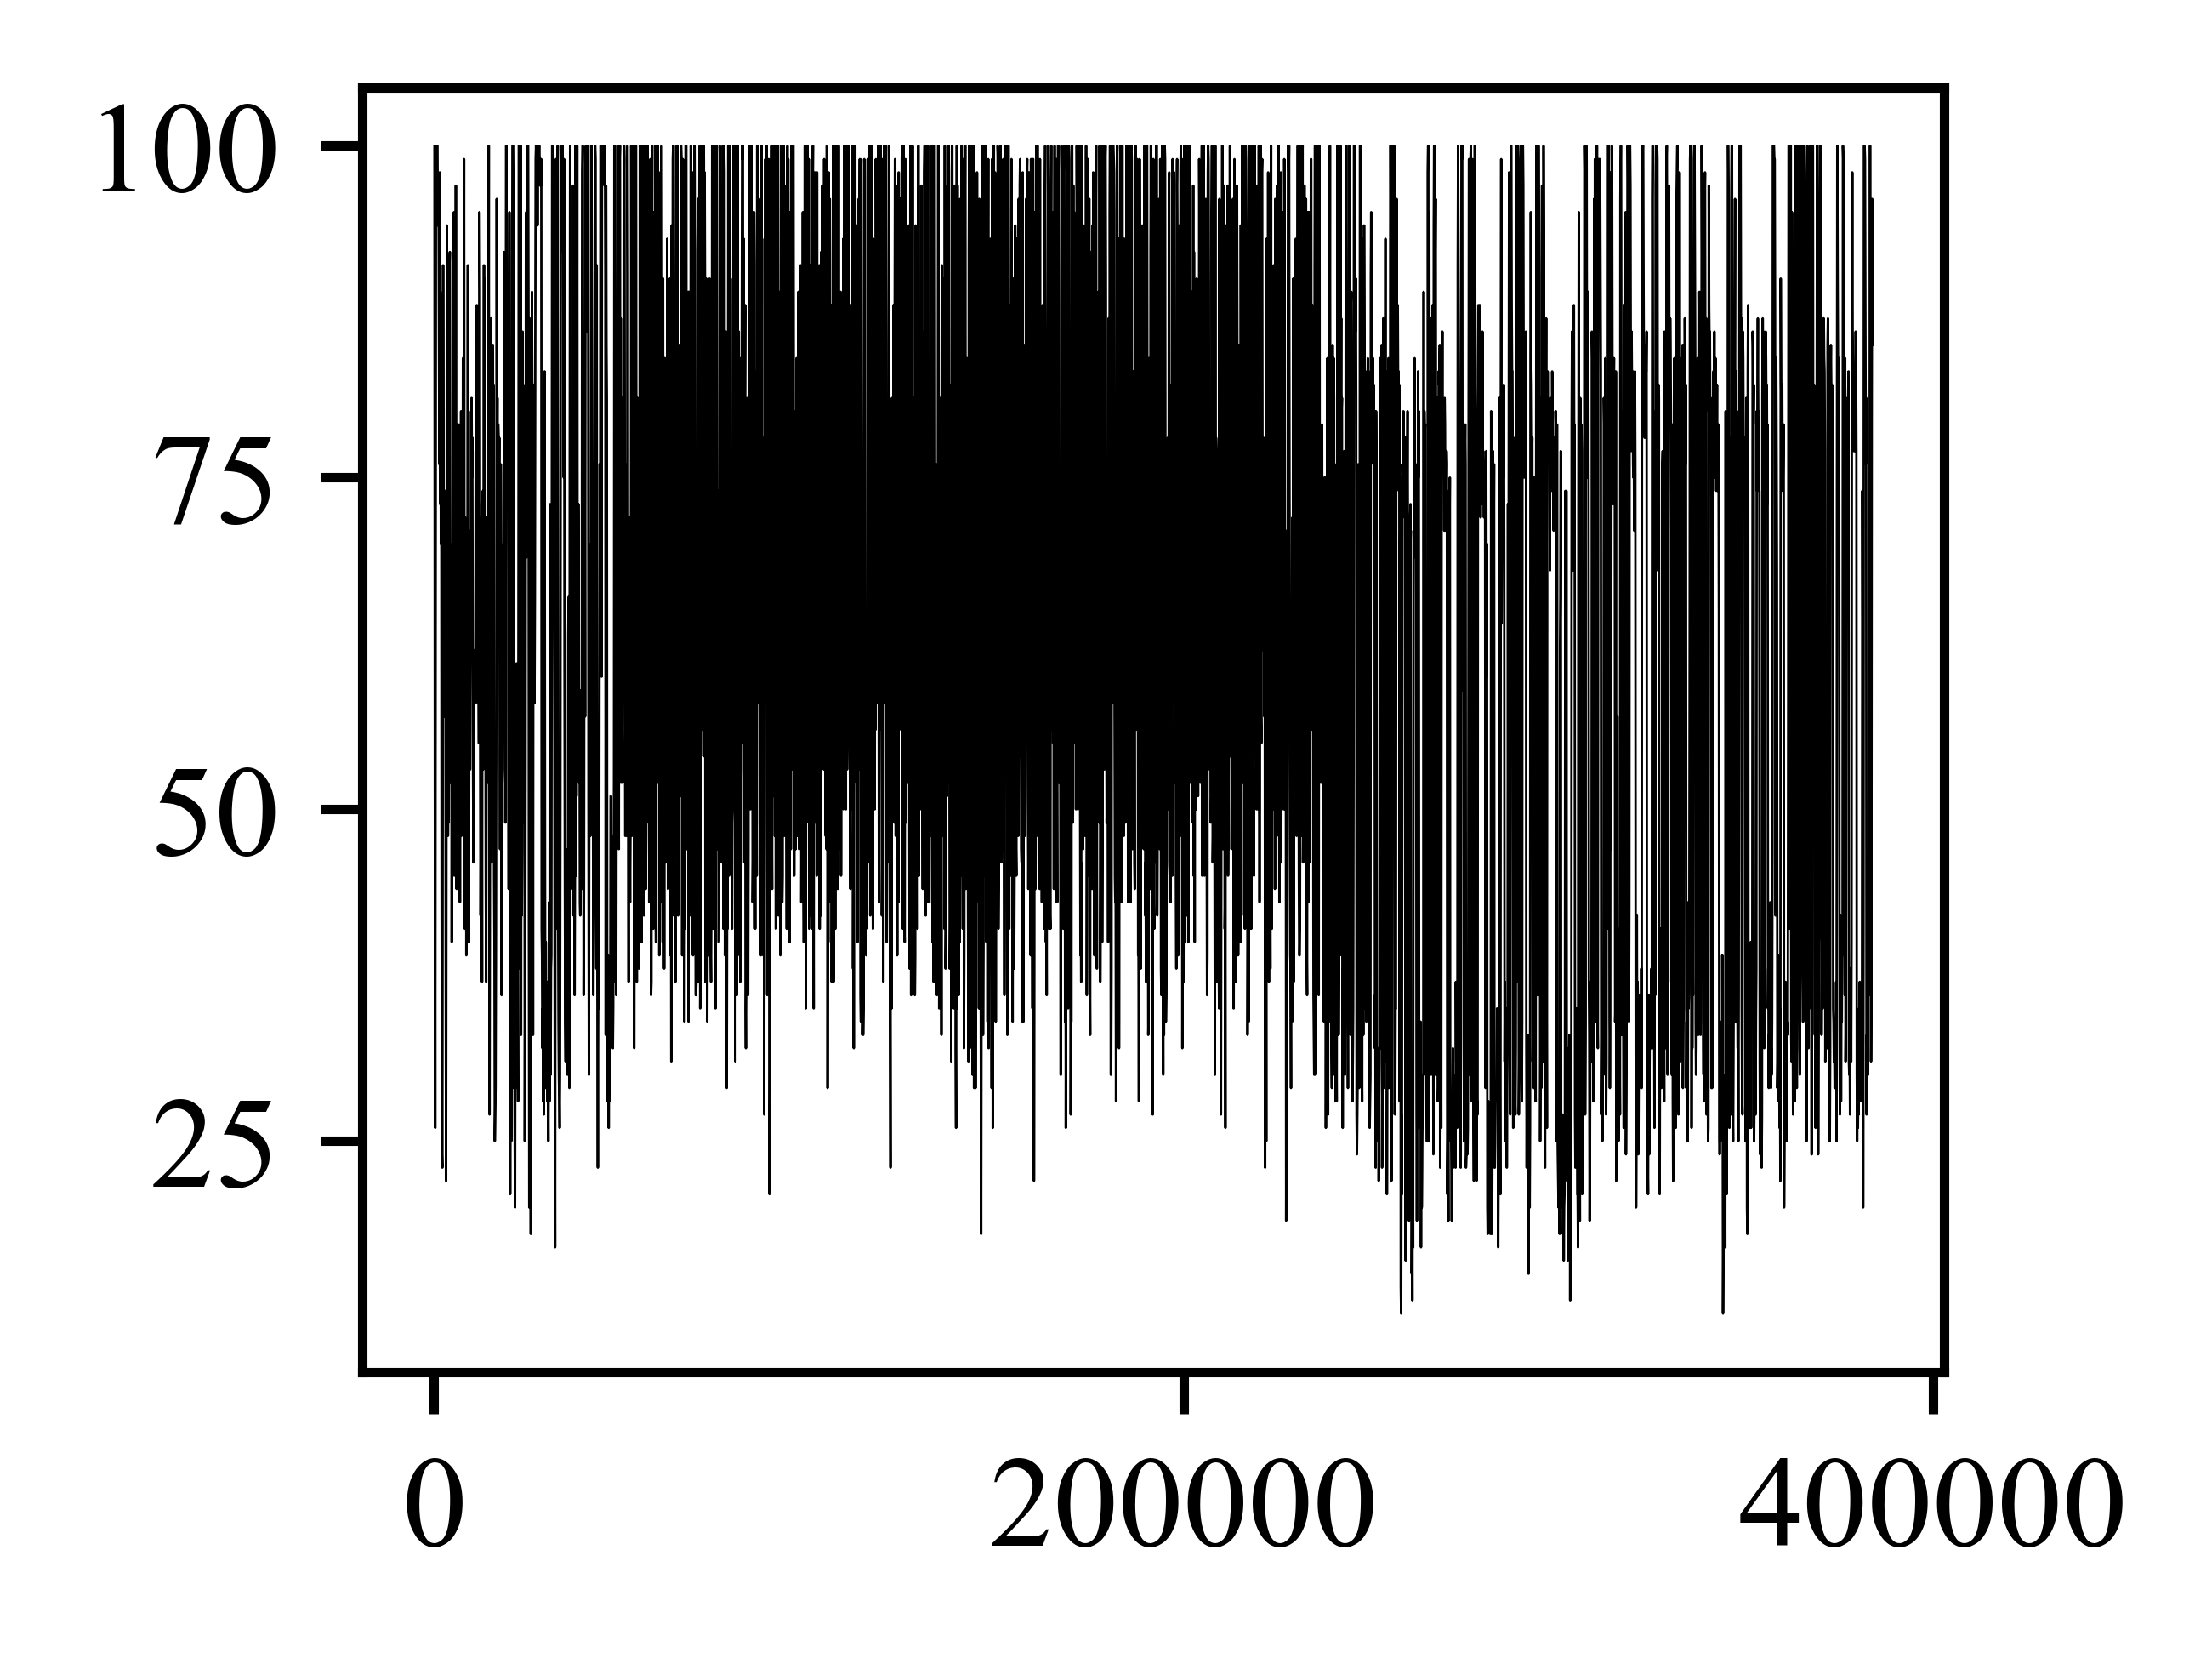

In [19]:
inf_df = pd.read_excel("C:/Users/manuf/OneDrive/Dokumente/Universitaet/Masterthesis/data/1_tuning_results/runtime_weights_infeas_normal.xlsx", "infeas")
inf_df = inf_df.iloc[:,:]
plt.plot(inf_df["iter"], inf_df["inf"], linewidth=0.2)

# 4) Mean removal dynamics

In [20]:
rep_df = pd.read_excel("C:/Users/manuf/OneDrive/Dokumente/Universitaet/Masterthesis/data/1_tuning_results/runtume_avg_remoal.xlsx")

Text(0.5,0,'iteration')

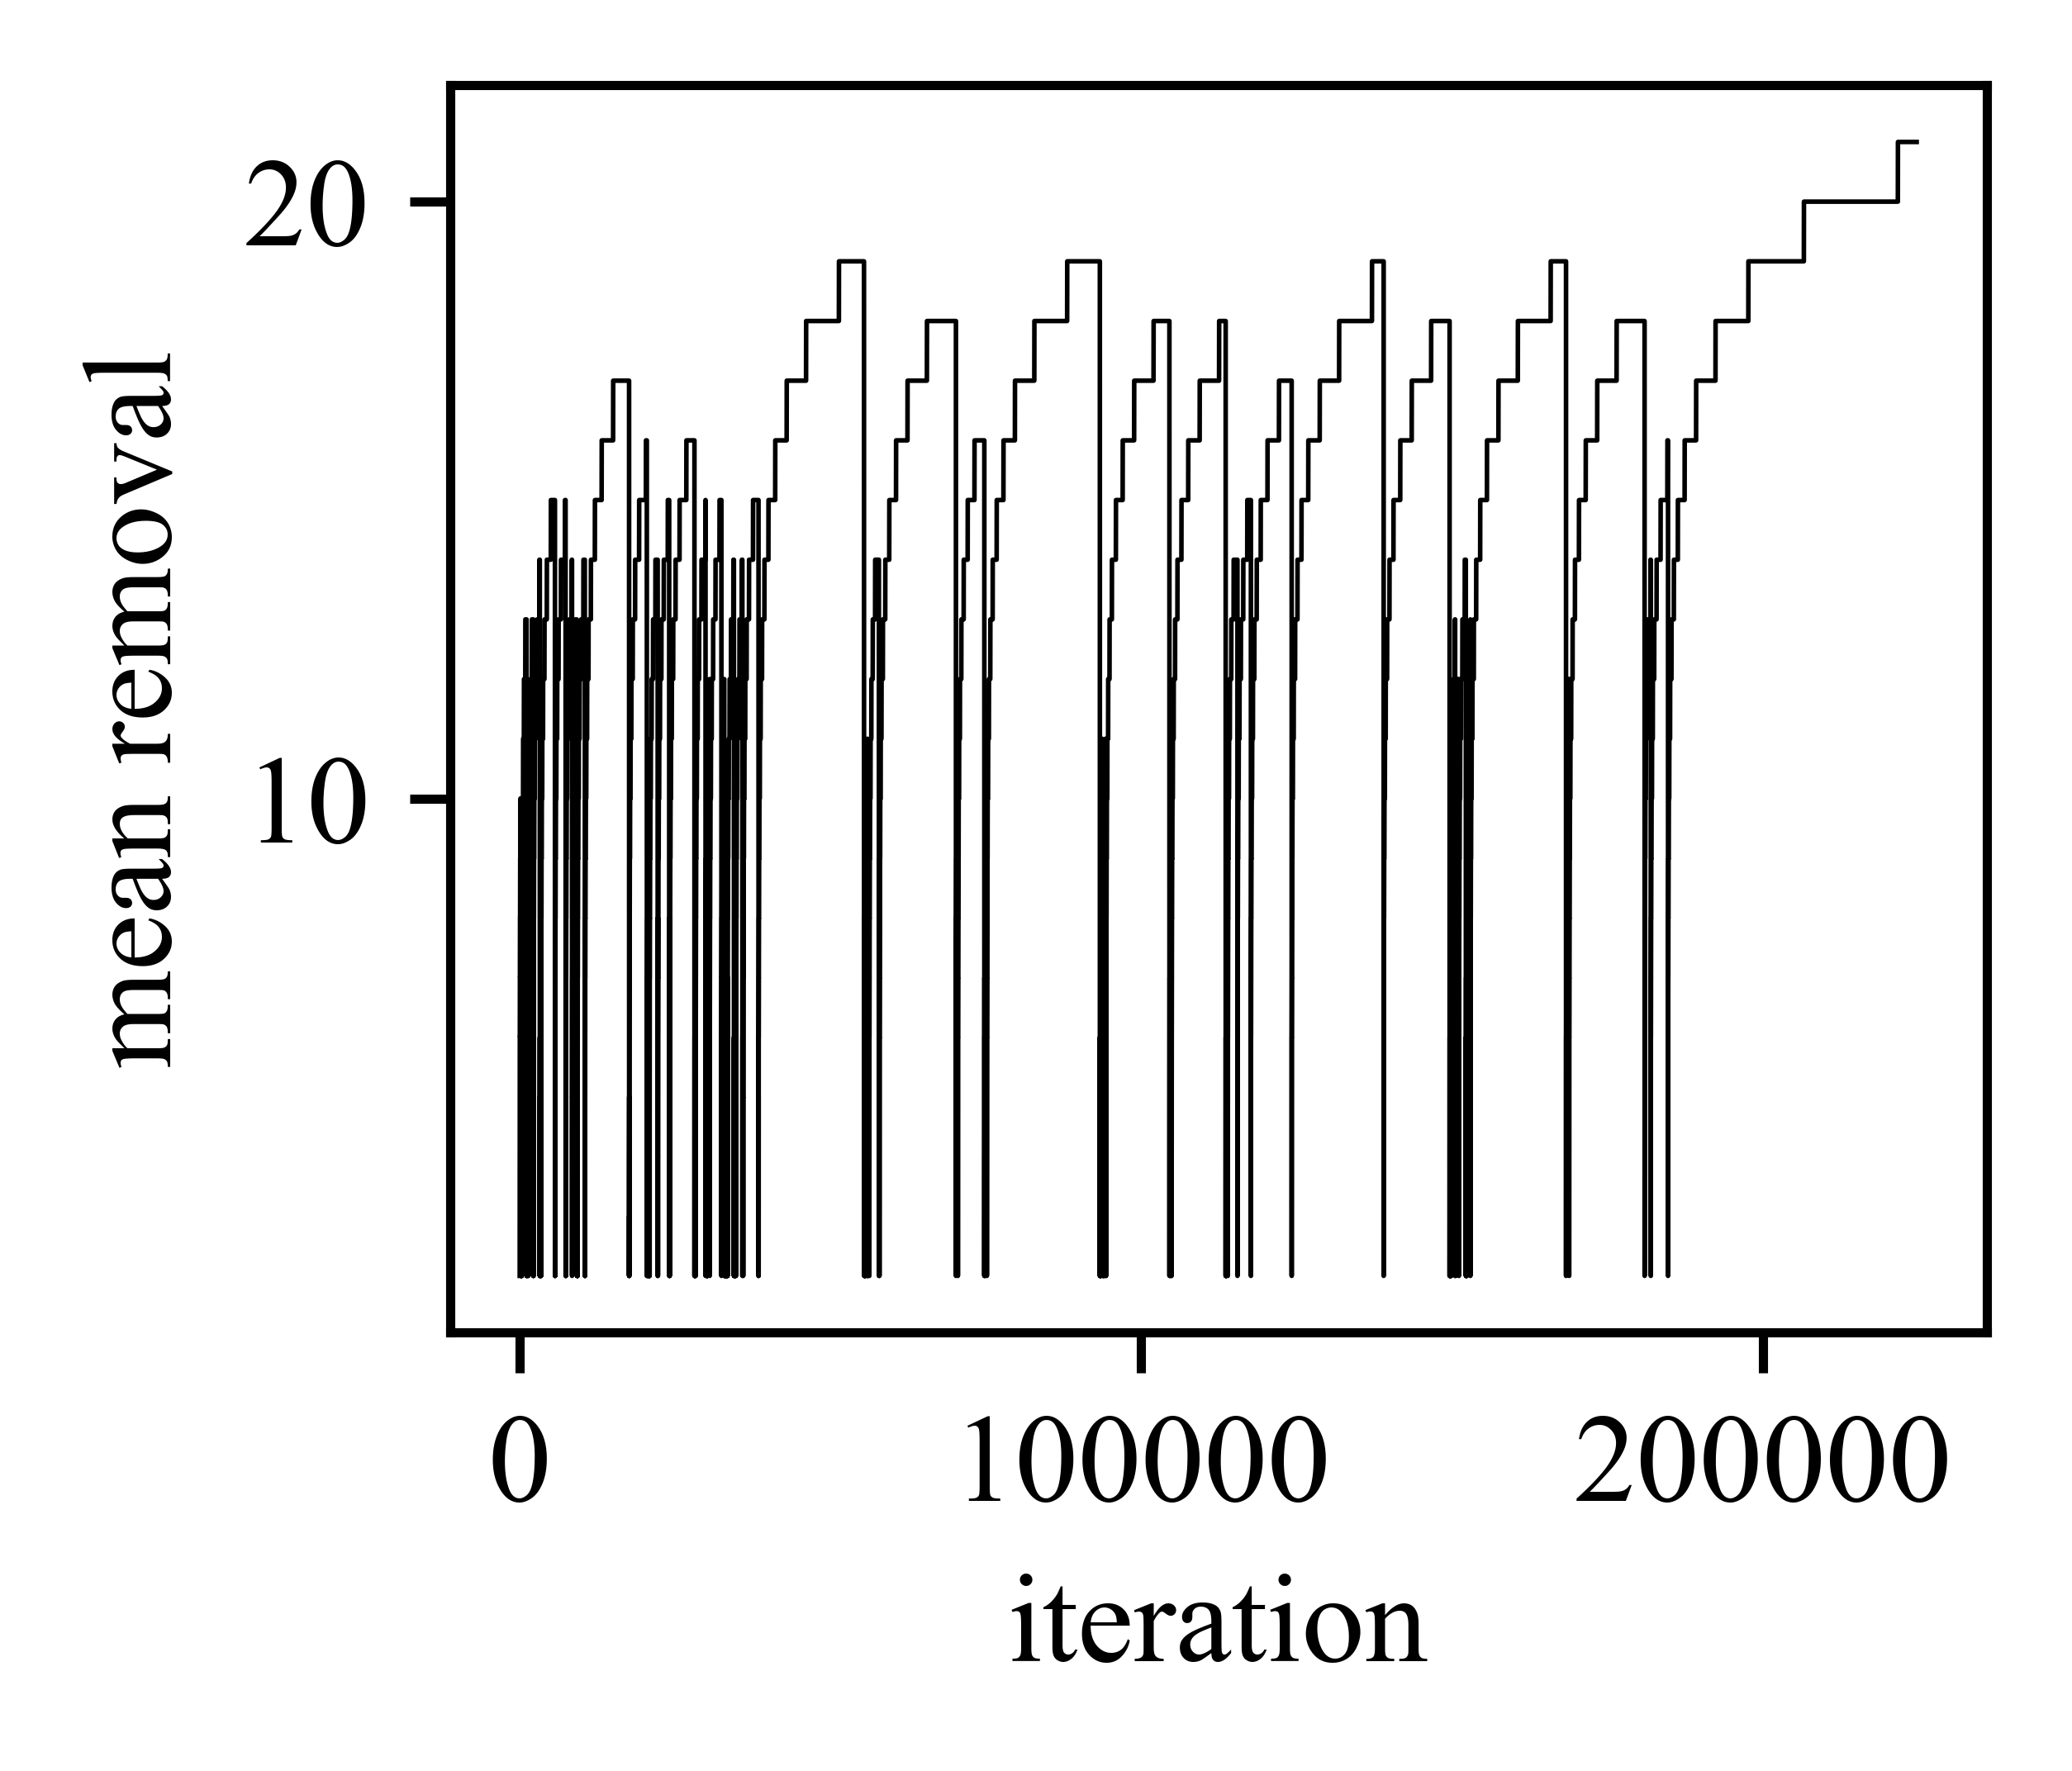

In [21]:
plt.style.use(("grayscale", "paper_hoch2"))
x = rep_df["iter"]
y1 = rep_df["rm"]

plt.plot(x, y1, linewidth=0.4)
plt.ylabel("mean removal")
plt.xlabel("iteration")
#plt.xlim(0, 750)